In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import matplotlib.dates as mpl_dates

In [3]:
ticker = input('Enter Ticker Symbol --> ')
interval_time = input('Enter Time Interval(valid intervals :- 1h, 1d, 5d, 1wk, 1mo, 3mo) --> ')

Enter Ticker Symbol --> INFY
Enter Time Interval(valid intervals :- 1h, 1d, 5d, 1wk, 1mo, 3mo) --> 1D


In [4]:
start_time = '2020-01-02'
today = date.today()
end_time = today.strftime("%Y-%m-%d")

In [5]:
data = pd.DataFrame()
data = yf.download(ticker, start = start_time, end = end_time, interval = interval_time)

data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,10.30,10.34,10.23,10.29,9.935719,5688000
2020-01-03,10.29,10.35,10.26,10.31,9.955031,6992200
2020-01-06,10.22,10.25,10.17,10.21,9.858474,10068900
2020-01-07,10.12,10.17,10.10,10.10,9.752262,10589100
2020-01-08,10.00,10.12,9.99,10.09,9.742607,13440400


In [6]:
no_of_business_days = int(input('For how many days are you going to keep the stock? '))

For how many days are you going to keep the stock? 3


In [7]:
result = []
train_size = 0.6

In [8]:
data['Forward Close'] = data['Close'].shift(no_of_business_days)
data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close']

In [9]:
for sma_length in range(20, 200):
    data['SMA'] = data['Close'].rolling(sma_length).mean()
    data['Signal'] = [int(x) for x in data['Close'] > data['SMA']]
    
    df = data.dropna()
    
    train_data = df.head(int(train_size*df.shape[0]))
    test_data = df.tail(int((1 - train_size)*df.shape[0]))
    
    train_returns = train_data[train_data['Signal'] == 1]['Forward Return'] 
    test_returns = test_data[test_data['Signal'] == 1]['Forward Return'] 
    
    mean_train_returns = train_returns.mean()
    mean_test_returns = test_returns.mean()
    
    pvalue = ttest_ind(train_returns,test_returns,equal_var=False)[1]
    
    result.append({
      'sma_length':sma_length,
      'training_forward_return': mean_train_returns,
      'test_forward_return': mean_test_returns,
      'p_value':pvalue
  })
    

In [10]:
result.sort(key = lambda x : -x['training_forward_return'])

In [11]:
sma_length = result[0]['sma_length']
p_value = result[0]['p_value']*100

In [12]:
def plot_graphs(df):
    plt.style.use('ggplot')
    
    fig, ax = plt.subplots()
    plt.plot(df['Close'], label="Close")
    plt.plot(df['SMA'], label="Simple Moving Average")
    ax.xaxis_date()
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title('Visualization of Moving Avegage and Closing Price')
    myFmt = mpl_dates.DateFormatter('%y-%m-%d')
    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()
    plt.legend(loc=2, bbox_to_anchor=(1.05, 1)) 
    
    plt.show()

Best Time Period for Moving Average is =  199 



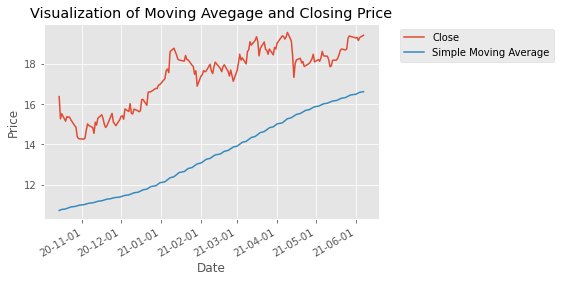

In [13]:
if p_value < 5:
    print('Calculated SMA Length can not be used in the real world')
else:
    print('Best Time Period for Moving Average is = ', sma_length, '\n')
    data['SMA'] = data['Close'].rolling(sma_length).mean()
    plot_graphs(df)